In [258]:
import os
import re
import string
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence

BATCH_SIZE = 32
EPOCHS = 5
MAX_LEN = 75
EMBEDDING = 20

def isEven(n):
    return n % 2 == 0

def filter_string(s):
    return ''.join(filter(lambda x: x in string.printable, s))

def split_words(s):
    return re.sub("[^\w]", " ",  s).split()

In [259]:
leis_dir = 'leis_vetadas/'
leis = []
leis_split = []
words = []
for fname in os.listdir(leis_dir):
    with open(leis_dir+fname, "r", encoding="utf-8") as f:
        r = f.read()
        leis.append(r)
        leis_split.append(r.split('**VETO**'))
        file_words = text_to_word_sequence(r)
        # file_words = split_words(r)
        words += file_words


In [268]:
#X_tmp = []
#y_tmp = []
sentences = []

for l in leis_split:
    i = 0
    sx = []
    sy = []
    for s in l:
        i += 1
        w = text_to_word_sequence(s)
        sx += w
        if isEven(i):
            sy += ["b-veto"]
            sy += ["veto" for _ in range(len(w)-2)]
            sy += ["e-veto"]
        else:
            sy += ['b-ok']
            sy += ["ok" for _ in range(len(w)-2)]
            sy += ['e-ok']
    sentences.append([[sx[a],sy[a]] for a in range(len(w))])

# sentences = list(zip(X_tmp, y_tmp))

In [269]:
vocab = list(set(words))
n_words = len(vocab)

tags = ["ok",'b-ok','e-ok',"veto",'b-veto','e-veto']
n_tags = len(tags)

word2idx = {w: i + 2 for i, w in enumerate(vocab)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

# Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}

# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}

print("The word Obama is identified by the index: {}".format(word2idx["paulo"]))
print("ok {}".format(tag2idx["ok"]))

from keras.preprocessing.sequence import pad_sequences
# Convert each sentence from list of Token to list of word_index
X = [[word2idx[w[0]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

# Convert Tag/Label to tag_index
y = [[tag2idx[w[1]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])

from keras.utils import to_categorical
# One-Hot encode
y = [to_categorical(i, num_classes=n_tags+1) for i in y]  # n_tags+1(PAD)

from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape

print('Raw Sample: ', ' '.join([w[0] for w in sentences[0]]))
print('Raw Label: ', ' '.join([w[1] for w in sentences[0]]))
print('After processing, sample:', X[0])
print('After processing, labels:', y[0])

The word Obama is identified by the index: 1274
ok 1
Raw Sample:  projeto de lei nº 283 de 2012 institui a semana de conscientização prevenção e combate a verminose no estado de são paulo e dá outras providências a assembleia legislativa do estado de são paulo decreta artigo 1º fica a secretaria estadual de saúde autorizada instituir a semana de conscientização prevenção e combate a verminose no estado de são paulo parágrafo único a semana de conscientização prevenção e combate a verminose no estado são paulo mencionada no caput deste artigo deverá obrigatoriamente abranger a primeira semana de abril artigo 2º os objetivos da semana de conscientização prevenção e combate a verminose no estado de são paulo i promover a conscientização e orientar com regras básicas de cuidados de higiene domiciliar e pessoal para evitar a contaminação através de profissionais qualificados ii criar a oportunidade de integração de órgãos e entidades públicos e privados em ações conjuntas em benefício da co

In [270]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
#from keras.layers import CRF

# Model definition
input = Input(shape=(MAX_LEN,))
model = Embedding(input_dim=n_words+2, output_dim=EMBEDDING, # n_words + 2 (PAD & UNK)
                  input_length=MAX_LEN, mask_zero=True)(input)  # default: 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags+1)  # CRF layer, n_tags+1(PAD)
out = crf(model)  # output

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 75)                0         
_________________________________________________________________
embedding_17 (Embedding)     (None, 75, 20)            91200     
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 75, 100)           28400     
_________________________________________________________________
time_distributed_17 (TimeDis (None, 75, 50)            5050      
_________________________________________________________________
crf_17 (CRF)                 (None, 75, 7)             420       
Total params: 125,070
Trainable params: 125,070
Non-trainable params: 0
_________________________________________________________________


In [271]:
history = model.fit(X_tr, np.array(y_tr), batch_size=BATCH_SIZE, epochs=200,
                    validation_split=0.25, verbose=2)

Train on 15 samples, validate on 5 samples
Epoch 1/200
 - 11s - loss: 3.2312 - crf_viterbi_accuracy: 9.9602e-04 - val_loss: 1.6882 - val_crf_viterbi_accuracy: 0.0000e+00
Epoch 2/200
 - 0s - loss: 3.1784 - crf_viterbi_accuracy: 0.0000e+00 - val_loss: 1.6167 - val_crf_viterbi_accuracy: 0.0000e+00
Epoch 3/200
 - 0s - loss: 3.1092 - crf_viterbi_accuracy: 0.0000e+00 - val_loss: 1.5218 - val_crf_viterbi_accuracy: 0.0000e+00
Epoch 4/200
 - 0s - loss: 3.0183 - crf_viterbi_accuracy: 0.1305 - val_loss: 1.3820 - val_crf_viterbi_accuracy: 0.9920
Epoch 5/200
 - 0s - loss: 2.8852 - crf_viterbi_accuracy: 0.9233 - val_loss: 1.1480 - val_crf_viterbi_accuracy: 0.9920
Epoch 6/200
 - 0s - loss: 2.6672 - crf_viterbi_accuracy: 0.9233 - val_loss: 0.6818 - val_crf_viterbi_accuracy: 0.9920
Epoch 7/200
 - 0s - loss: 2.2439 - crf_viterbi_accuracy: 0.9233 - val_loss: 0.1030 - val_crf_viterbi_accuracy: 0.9920
Epoch 8/200
 - 0s - loss: 1.9151 - crf_viterbi_accuracy: 0.9233 - val_loss: 0.1053 - val_crf_viterbi_accur

Epoch 70/200
 - 0s - loss: 1.4926 - crf_viterbi_accuracy: 0.9900 - val_loss: 0.0267 - val_crf_viterbi_accuracy: 0.9920
Epoch 71/200
 - 0s - loss: 1.5060 - crf_viterbi_accuracy: 0.9761 - val_loss: 0.0732 - val_crf_viterbi_accuracy: 0.9680
Epoch 72/200
 - 0s - loss: 1.5077 - crf_viterbi_accuracy: 0.9811 - val_loss: 0.0276 - val_crf_viterbi_accuracy: 0.9920
Epoch 73/200
 - 0s - loss: 1.4977 - crf_viterbi_accuracy: 0.9880 - val_loss: 0.0290 - val_crf_viterbi_accuracy: 0.9920
Epoch 74/200
 - 0s - loss: 1.4897 - crf_viterbi_accuracy: 0.9880 - val_loss: 0.0271 - val_crf_viterbi_accuracy: 0.9920
Epoch 75/200
 - 0s - loss: 1.4843 - crf_viterbi_accuracy: 0.9920 - val_loss: 0.0267 - val_crf_viterbi_accuracy: 0.9920
Epoch 76/200
 - 0s - loss: 1.4846 - crf_viterbi_accuracy: 0.9880 - val_loss: 0.0260 - val_crf_viterbi_accuracy: 0.9920
Epoch 77/200
 - 0s - loss: 1.4858 - crf_viterbi_accuracy: 0.9920 - val_loss: 0.0263 - val_crf_viterbi_accuracy: 0.9920
Epoch 78/200
 - 0s - loss: 1.4861 - crf_viterbi_

Epoch 139/200
 - 0s - loss: 1.4409 - crf_viterbi_accuracy: 0.9960 - val_loss: 0.0232 - val_crf_viterbi_accuracy: 0.9947
Epoch 140/200
 - 0s - loss: 1.4346 - crf_viterbi_accuracy: 0.9980 - val_loss: 0.0233 - val_crf_viterbi_accuracy: 0.9947
Epoch 141/200
 - 0s - loss: 1.4340 - crf_viterbi_accuracy: 0.9980 - val_loss: 0.0234 - val_crf_viterbi_accuracy: 0.9947
Epoch 142/200
 - 0s - loss: 1.4349 - crf_viterbi_accuracy: 0.9980 - val_loss: 0.0237 - val_crf_viterbi_accuracy: 0.9947
Epoch 143/200
 - 0s - loss: 1.4377 - crf_viterbi_accuracy: 0.9960 - val_loss: 0.0232 - val_crf_viterbi_accuracy: 0.9947
Epoch 144/200
 - 0s - loss: 1.4367 - crf_viterbi_accuracy: 0.9960 - val_loss: 0.0239 - val_crf_viterbi_accuracy: 0.9947
Epoch 145/200
 - 0s - loss: 1.4332 - crf_viterbi_accuracy: 0.9980 - val_loss: 0.0232 - val_crf_viterbi_accuracy: 0.9947
Epoch 146/200
 - 0s - loss: 1.4341 - crf_viterbi_accuracy: 0.9970 - val_loss: 0.0251 - val_crf_viterbi_accuracy: 0.9947
Epoch 147/200
 - 0s - loss: 1.4321 - crf

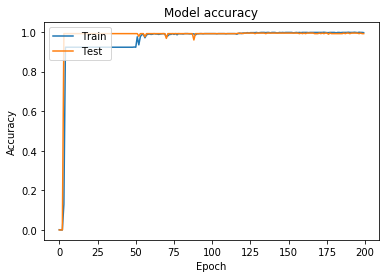

In [272]:
plt.plot(history.history['crf_viterbi_accuracy'])
plt.plot(history.history['val_crf_viterbi_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

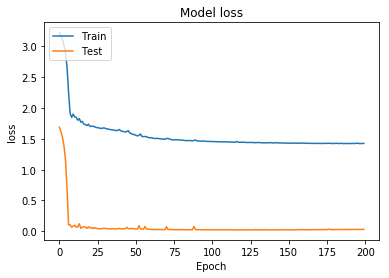

In [273]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [274]:
# Eval
pred_cat = model.predict(X_te)
pred = np.argmax(pred_cat, axis=-1)
y_te_true = np.argmax(y_te, -1)

from sklearn_crfsuite.metrics import flat_classification_report

# Convert the index to tag
pred_tag = [[idx2tag[i] for i in row] for row in pred]
y_te_true_tag = [[idx2tag[i] for i in row] for row in y_te_true] 

report = flat_classification_report(y_pred=pred_tag, y_true=y_te_true_tag)
print(report)

              precision    recall  f1-score   support

         PAD       1.00      1.00      1.00        54
        b-ok       1.00      0.25      0.40         4
      b-veto       0.00      0.00      0.00         2
        e-ok       0.00      0.00      0.00         2
      e-veto       0.00      0.00      0.00         3
          ok       0.70      1.00      0.82       119
        veto       0.00      0.00      0.00        41

   micro avg       0.77      0.77      0.77       225
   macro avg       0.39      0.32      0.32       225
weighted avg       0.63      0.77      0.68       225

